# This is the sep tutorial using astropy instead of fitsio.

In [16]:
import sep
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
%matplotlib inline

## Opening the image.
Note: The FITS folder must be on the Desktop

In [17]:
# Download the image through the astropy.utils.data.download_file function
image_file = download_file('https://github.com/kbarbary/sep/blob/master/data/image.fits?raw=true', cache=True )

# Open the fits file through the astropy.io.fits class
hdul = fits.open(image_file)

# Set the first entry in hdul equal to data so that
# it can be placed in a standard 2-D numpy array
data = hdul[0].data

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


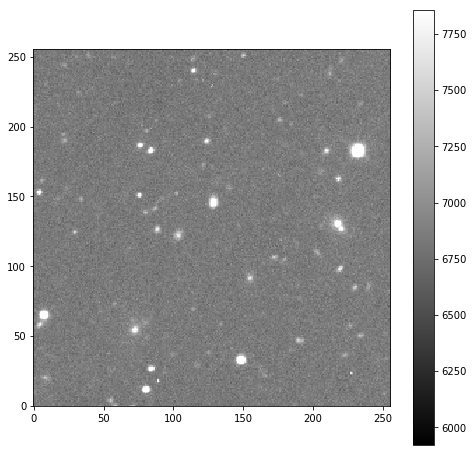

In [18]:
# Show the image
m, s = np.mean(data), np.std(data)
plt.figure(figsize=(8,8))
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()

# Save the image
plt.savefig('image_direct.png');

## Background Subtraction

In [19]:
# Measure a spatially varying background on the image
bkg = sep.Background(data)

In [20]:
# Get a "global" mean and noise of the image background
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [21]:
# Evaluate the background as a 2-D array of the same
# size as the original
bkg_image = bkg.back()
# bkg_image = np.array(bkg) would be the same as the
# equation above

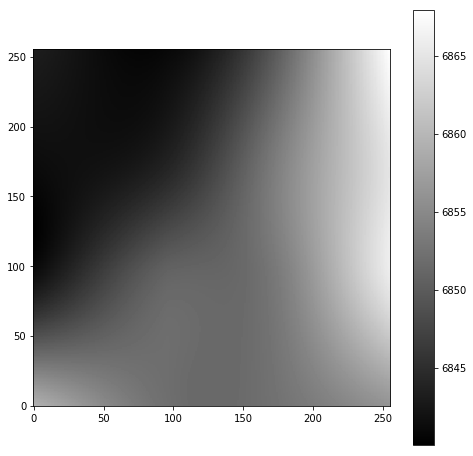

In [22]:
# Show the background
plt.figure(figsize=(8,8))
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

# Save the image
plt.savefig('image_back.png');

In [23]:
# Evaluate the background noise as a 2-D array of
# the same size as the original
bkg_rms = bkg.rms()

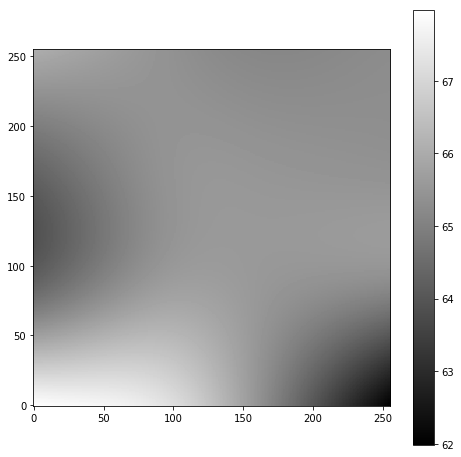

In [24]:
# Show the background noise
plt.figure(figsize=(8,8))
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

# Save the image
plt.savefig('image_rms.png');

In [25]:
# Subtract the background
data_sub = data - bkg
# This is needed in order detect the objects in the image

## Object Detection

In [26]:
# Set the detection threshold to be 1.5 times the
# global background RMS.
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [27]:
# This will return how many objects were detected
len(objects)

68

Note: this output is 1 higher than that of the tutorial. This is because this image has a bkg.globalrms that is 0.0001 higher than that in the tutorial.

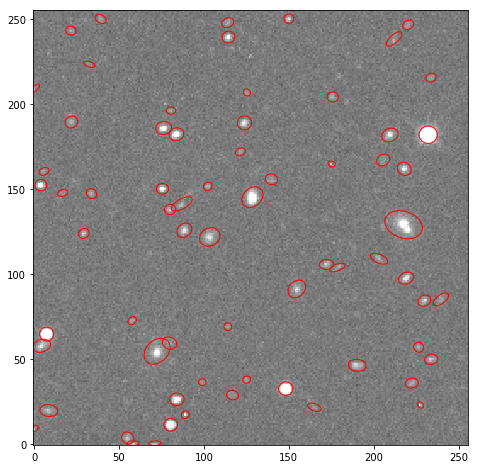

In [28]:
from matplotlib.patches import Ellipse

# Plot the background-subtracted image
fig, ax = plt.subplots(figsize=(8,8))
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# Plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),width=6*objects['a'][i],height=6*objects['b'][i],angle=objects['theta'][i]*180/(2*np.pi))
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

# Save the image
plt.savefig('image_final.png')

Note: The objects function has many fields. All of the fields can be seen by typing objects.dtypes.names

## Aperature Photometry
Simple circular aperature photometry with a 3 pixel radius at the locations of the objects will be performed.

In [29]:
# Flux, fluxerr, and flag are all 1-D arrays with one entry per object
flux, fluxerr, flag = sep.sum_circle(data_sub,objects['x'],objects['y'],3.0,err=bkg.globalrms,gain=1.0)

In [30]:
# Show the first ten objects' results
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i,flux[i],fluxerr[i]))

object 0: flux = 2249.159297 +/- 291.027802
object 1: flux = 3092.220430 +/- 291.592204
object 2: flux = 5949.868379 +/- 356.562003
object 3: flux = 1851.426582 +/- 295.028816
object 4: flux = 72736.386914 +/- 440.172206
object 5: flux = 3860.756152 +/- 352.163162
object 6: flux = 6418.913789 +/- 357.458973
object 7: flux = 2210.707656 +/- 350.791223
object 8: flux = 2741.607227 +/- 352.277746
object 9: flux = 20916.875566 +/- 376.966138


## A brief word on byte order

#### For astropy.io.fits, it is possible for this ValueError to arise:

ValueError: Input array with dtype '>f4' has non-native byte order.
Only native byte order arrays are supported. To change the byte
order of the array 'data', do 'data = data.byteswap().newbyteorder()'

#### It is usually easiest to do this byte-swap operation directly after reading the array from the FITS file. You can even perform the byte swap in-place by doing:

data = data.byteswap(inplace=True).newbyteorder()

#### Ensure that there are no references to 'data' after this as they will be rendered nonsensical.